## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from typing import Dict, List, Tuple, Any, Optional

/Users/alex/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Jain's Fairness Index calculation

In [2]:
def jain_fairness_index(window_sizes: np.ndarray) -> float:
    """
    Calculate Jain's Fairness Index for window sizes
    JFI = (sum(x_i))^2 / (n * sum(x_i^2))
    Range: [1/n, 1], where 1 is perfectly fair
    """
    n = len(window_sizes)
    if n == 0 or np.sum(window_sizes) == 0:
        return 0.0
    
    numerator = np.sum(window_sizes) ** 2
    denominator = n * np.sum(window_sizes ** 2)
    
    return numerator / denominator

### AIMD algorithm's increase function (Additive Increase, Multiplicative Decrease)
#### Returns a constant increase

In [3]:
def aimd_increase(cwnd: float, alpha_add: float, **kwargs) -> float:
    """
    AIMD increase function: x_i(t+1) = x_i(t) + α
    """
    return alpha_add

### MIMD algorithm's increase function (Multiplicative Increase, Multiplicative Decrease)
#### Returns a proportionate increase

In [4]:
def mimd_increase(cwnd: float, alpha_mult: float, **kwargs) -> float:
    """
    MIMD increase function: x_i(t+1) = x_i(t) * α
    """
    return alpha_mult * cwnd

### Hybrid AIMD-MIMD algorithm's increase function
#### Returns something between a constant and proportionate increase

In [5]:
def hybrid_increase(cwnd: float, alpha_add: float, alpha_mult: float, 
                    w_low: float, w_high: float, **kwargs) -> float:
    """
    Hybrid AIMD-MIMD increase function:
    - If cwnd < w_low: Use AIMD (cwnd += alpha_add)
    - If cwnd > w_high: Use MIMD (cwnd += alpha_mult * cwnd)
    - Otherwise: Linear interpolation between the two
    """
    if cwnd < w_low:
        # Pure AIMD behavior
        return alpha_add
    elif cwnd > w_high:
        # Pure MIMD behavior
        return alpha_mult * cwnd
    else:
        # Linear interpolation between AIMD and MIMD
        ratio = (cwnd - w_low) / (w_high - w_low)
        add_component = alpha_add * (1 - ratio)
        mult_component = alpha_mult * cwnd * ratio
        return add_component + mult_component

### Hybrid Power algorithm's increase function
#### Returns a power-law scaled increase

In [6]:
def hybrid_power_increase(cwnd: float, alpha_add: float, w_low: float, 
                          power: float, **kwargs) -> float:
    """
    Hybrid Power increase function:
    - If cwnd < w_low: Use AIMD (cwnd += alpha_add)
    - Otherwise: Use power function (cwnd += alpha_add * (cwnd/w_low)^power)
    """
    if cwnd < w_low:
        # Pure AIMD below threshold
        return alpha_add
    else:
        # Power function scaling - more aggressive with larger windows
        power_factor = (cwnd / w_low) ** power
        return alpha_add * power_factor

### Helper: Dictionary mapping algorithm names to their increase functions

In [7]:
INCREASE_FUNCTIONS = {
    "aimd": aimd_increase,
    "mimd": mimd_increase,
    "hybrid": hybrid_increase,
    "hybrid_power": hybrid_power_increase
}

### Simulation function
#### Simulates multiple TCP-like flows sharing a single bottleneck, including optional RTT variation used to distinguish between basic and hetereogenous flows
#### Also records convergence-related metrics (fairness, utilization, etc.) to access how well each algorithm performs

In [8]:
# Set random seed for reproducibility
np.random.seed(42)

In [9]:
def simulate_tcp(algorithm: str, 
                num_flows: int,
                capacity: float,
                iterations: int = 300,
                beta: float = 0.5,
                min_cwnd: float = 1.0,
                rtt_heterogeneity: float = 0.0,
                **algorithm_params) -> Dict[str, Any]:
    """
    Simulate TCP congestion control with multiple flows sharing a bottleneck
    """    
    # Get the appropriate increase function
    increase_function = INCREASE_FUNCTIONS[algorithm]
    
    # Initialize congestion windows - start with random values
    init_min = max(min_cwnd, 1.0)
    init_max = max(min_cwnd + 5.0, capacity / (2 * num_flows))
    cwnd = np.random.uniform(init_min, init_max, num_flows)
    
    # Generate RTT multipliers for each flow (1.0 = baseline RTT)
    max_rtt_ratio = 1.0 + 2.0 * rtt_heterogeneity
    if rtt_heterogeneity > 0:
        rtt_multipliers = np.random.uniform(1.0, max_rtt_ratio, num_flows)
    else:
        rtt_multipliers = np.ones(num_flows)
    
    # History tracking
    cwnd_history = [cwnd.copy()]
    fairness_history = [jain_fairness_index(cwnd)]
    utilization_history = [min(np.sum(cwnd) / capacity, 1.0)]  # Cap at 1.0
    flow_count_history = [num_flows]
    
    # Convergence tracking
    convergence_iter = -1
    steady_state_counter = 0
    
    # Main simulation loop
    for t in range(1, iterations):
        # Current number of flows
        current_num_flows = len(cwnd)
        
        # Detect congestion
        total_window = np.sum(cwnd)
        is_congested = total_window > capacity
        
        # Update each flow's window
        for i in range(current_num_flows):
            # Only update every RTT cycle, scaled by the flow's RTT multiplier
            update_probability = 1.0 / rtt_multipliers[i]
            if np.random.random() <= update_probability:
                if is_congested:
                    # Multiplicative decrease
                    cwnd[i] *= (1.0 - beta)
                else:
                    # Increase based on algorithm, scaled by RTT multiplier
                    increase = increase_function(
                        cwnd=cwnd[i],
                        **algorithm_params
                    ) / rtt_multipliers[i]
                    
                    cwnd[i] += increase
                
                # Ensure minimum window size
                cwnd[i] = max(cwnd[i], min_cwnd)
        
        # Record history
        cwnd_history.append(cwnd.copy())
        fairness = jain_fairness_index(cwnd)
        fairness_history.append(fairness)
        utilization = min(np.sum(cwnd) / capacity, 1.0)  # Cap at 1.0
        utilization_history.append(utilization)
        flow_count_history.append(current_num_flows)
        
        # Check for convergence (after burn-in period)
        if t >= 20 and convergence_iter < 0:
            # Relax convergence criteria
            if (fairness >= 0.9 and  
                utilization >= 0.8):  
                steady_state_counter += 1
                if steady_state_counter >= 5:  
                    # We've been in steady state for enough iterations
                    convergence_iter = t - steady_state_counter + 1
            else:
                steady_state_counter = 0
    
    # Calculate metrics
    # 1. Final fairness and utilization
    final_fairness = fairness_history[-1]
    final_utilization = utilization_history[-1]
    
    # 2. Fairness and utilization over time (area under curve)
    fairness_auc = np.trapz(fairness_history) / iterations
    utilization_auc = np.trapz(utilization_history) / iterations
    
    # 3. Oscillation amplitude (in steady state or entire run if no convergence)
    if convergence_iter >= 0:
        steady_state_util = utilization_history[convergence_iter:]
        oscillation_amplitude = np.max(steady_state_util) - np.min(steady_state_util)
    else:
        oscillation_amplitude = np.max(utilization_history) - np.min(utilization_history)
    
    # Package results
    # Handle variable-sized cwnd_history with a ragged array approach
    # Store only the first 5 flows for visualization purposes
    cwnd_history_fixed = []
    for t in range(len(cwnd_history)):
        if t < len(cwnd_history):
            hist_t = cwnd_history[t]
            # Take only the first 5 flows or fewer if not enough flows
            num_flows_t = min(5, len(hist_t))
            cwnd_history_fixed.append(hist_t[:num_flows_t])
    
    results = {
        "algorithm": algorithm,
        "num_flows": num_flows,
        "capacity": capacity,
        "iterations": iterations,
        "convergence_iter": convergence_iter,
        "final_fairness": final_fairness,
        "final_utilization": final_utilization,
        "fairness_auc": fairness_auc,
        "utilization_auc": utilization_auc,
        "oscillation_amplitude": oscillation_amplitude,
        "cwnd_history": cwnd_history_fixed,  # Store as a list instead of numpy array
        "fairness_history": np.array(fairness_history),
        "utilization_history": np.array(utilization_history),
        "flow_count_history": np.array(flow_count_history),
        "parameters": {
            **algorithm_params, 
            "beta": beta,
            "rtt_heterogeneity": rtt_heterogeneity
        }
    }
    
    return results

### Experiment function
#### Calls the simulation function with the appropriate parameters required for the 2 types of scenarios: Basic & Heterogeneous

In [10]:
def run_algorithm_comparison(num_flows_list=[5, 10, 20, 50], 
                            capacity=100.0,
                            scenarios=["basic", "heterogeneous"]):
    """
    Run comparative experiments for different algorithms across fixed RTT and varied RTT scenarios
    """
    # Define algorithms and their parameters
    algorithms = {
        "aimd": {"alpha_add": 1.0, "beta": 0.5},
        "mimd": {"alpha_mult": 0.05, "beta": 0.5},
        "hybrid": {"alpha_add": 0.5, "alpha_mult": 0.05, "w_low": 10.0, "w_high": 30.0, "beta": 0.4},
        "hybrid_power": {"alpha_add": 0.5, "w_low": 10.0, "power": 1.5, "beta": 0.4}
    }
    
    # Setup experiment scenarios
    scenario_settings = {
        "basic": {"rtt_heterogeneity": 0.0},
        "heterogeneous": {"rtt_heterogeneity": 0.5}
    }
    
    # Store all results
    all_results = {}
    
    # Run experiments for each scenario
    for scenario in scenarios:
        print(f"\nRunning {scenario} scenario...")
        scenario_params = scenario_settings[scenario]
        
        # Run each algorithm for different flow counts
        scenario_results = {}
        for num_flows in num_flows_list:
            print(f"  Testing with {num_flows} flows")
            
            for alg_name, alg_params in algorithms.items():
                # Run simulation
                result = simulate_tcp(
                    algorithm=alg_name,
                    num_flows=num_flows,
                    capacity=capacity,
                    iterations=300,
                    **alg_params,
                    **scenario_params
                )
                
                # Store result
                key = (scenario, alg_name, num_flows)
                scenario_results[key] = result
                
                # Print brief summary
                converged = "Yes" if result["convergence_iter"] >= 0 else "No"
                print(f"    {alg_name}: Fairness={result['final_fairness']:.3f}, " +
                      f"Utilization={result['final_utilization']:.3f}, Converged={converged}")
        
        all_results.update(scenario_results)
    
    return all_results

### Visualization functions

In [11]:
def plot_algorithm_comparison(results, scenario, num_flows, alg_names):
    """
    Plot comparison of algorithms for a specific scenario and flow count
    """
    # Setup figure
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'TCP Algorithm Comparison - {scenario.capitalize()} Scenario, {num_flows} Flows', fontsize=16)
    
    # 1. Fairness over time
    ax = axs[0, 0]
    for alg in alg_names:
        key = (scenario, alg, num_flows)
        if key in results:
            ax.plot(results[key]["fairness_history"], label=alg)
    
    ax.axhline(y=0.9, color='black', linestyle='--', alpha=0.5, label='Fairness Threshold (0.9)')
    ax.set_title('Fairness Index Over Time')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Jain\'s Fairness Index')
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Utilization over time
    ax = axs[0, 1]
    for alg in alg_names:
        key = (scenario, alg, num_flows)
        if key in results:
            ax.plot(results[key]["utilization_history"], label=alg)
    
    ax.axhline(y=1.0, color='black', linestyle='--', alpha=0.5, label='Full Capacity')
    ax.set_title('Link Utilization Over Time')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Utilization (sum(cwnd)/capacity)')
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Window evolution for first flow
    ax = axs[1, 0]
    for alg in alg_names:
        key = (scenario, alg, num_flows)
        if key in results:
            # Extract first flow's window size - handle as list safely
            try:
                flow_windows = []
                for cwnd in results[key]["cwnd_history"]:
                    if len(cwnd) > 0:  # Make sure there's at least one flow
                        flow_windows.append(cwnd[0])
                    else:
                        flow_windows.append(0)  # Fallback if no flows
                ax.plot(flow_windows, label=alg)
            except Exception as e:
                print(f"Error plotting window evolution for {alg}: {e}")
    
    # Only attempt to draw fair share line if we have results
    if len(results) > 0:
        key = (scenario, alg_names[0], num_flows)  # Use first algorithm as reference
        if key in results:
            ax.axhline(y=results[key]["capacity"]/num_flows, color='black', linestyle='--', 
                    alpha=0.5, label=f'Fair Share ({results[key]["capacity"]/num_flows:.1f})')
    
    ax.set_title('Flow 1 Window Evolution')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Congestion Window Size')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Summary metrics
    ax = axs[1, 1]
    ax.axis('off')
    
    # Create a table to display metrics
    data = []
    columns = ['Algorithm', 'Fairness', 'Utilization', 'Convergence Iter.', 'Oscillation']
    
    for alg in alg_names:
        key = (scenario, alg, num_flows)
        if key in results:
            r = results[key]
            conv_iter = r["convergence_iter"] if r["convergence_iter"] >= 0 else "Did not converge"
            data.append([
                alg,
                f"{r['final_fairness']:.3f}",
                f"{r['final_utilization']:.3f}",
                conv_iter,
                f"{r['oscillation_amplitude']:.3f}"
            ])
    
    table = ax.table(cellText=data, colLabels=columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)
    
    plt.tight_layout()
    return fig

def create_summary_plot(results, scenarios, num_flows_list, alg_names):
    """
    Create summary plots to compare algorithm performance across different scenarios
    """
    # Create metrics DataFrame
    rows = []
    for scenario in scenarios:
        for num_flows in num_flows_list:
            for alg in alg_names:
                key = (scenario, alg, num_flows)
                if key in results:
                    r = results[key]
                    rows.append({
                        'Scenario': scenario.capitalize(),
                        'Algorithm': alg,
                        'NumFlows': num_flows,
                        'Fairness': r['final_fairness'],
                        'Utilization': r['final_utilization'],
                        'FairnessAUC': r['fairness_auc'],
                        'UtilizationAUC': r['utilization_auc'],
                        'Oscillation': r['oscillation_amplitude'],
                        'Converged': r['convergence_iter'] >= 0
                    })
    
    df = pd.DataFrame(rows)
    
    # Create combined score (weighted average of metrics)
    df['Score'] = (0.3 * df['Fairness'] + 
                  0.3 * df['Utilization'] + 
                  0.2 * df['FairnessAUC'] + 
                  0.1 * df['UtilizationAUC'] + 
                  0.1 * (1 - df['Oscillation']))  # Lower oscillation is better
    
    # Create summary heatmap
    plt.figure(figsize=(15, 10))
    
    # Create pivot table for the heatmap
    pivot = df.pivot_table(
        index=['Scenario', 'NumFlows'],
        columns='Algorithm',
        values='Score',
        aggfunc='mean'
    )
    
    # Plot heatmap
    ax = sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis", 
                    linewidths=.5, cbar_kws={'label': 'Performance Score'})
    ax.set_title('Algorithm Performance Across Scenarios and Flow Counts', fontsize=16)
    plt.tight_layout()
    
    # Create bar chart to compare overall performance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Algorithm', y='Score', data=df, ci=None)
    plt.title('Overall Algorithm Performance', fontsize=16)
    plt.ylim(0, 1)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    # Create radar chart to compare performance dimensions
    
    # Calculate mean metrics by algorithm
    metrics = ['Fairness', 'Utilization', 'FairnessAUC', 'UtilizationAUC']
    radar_df = df.groupby('Algorithm')[metrics].mean().reset_index()

    # Add inverted oscillation (lower is better)
    oscillation_dict = df.groupby('Algorithm')['Oscillation'].mean().to_dict()
    radar_df['LowOscillation'] = radar_df['Algorithm'].map(
        lambda alg: 1 - oscillation_dict[alg] / max(oscillation_dict.values()) if max(oscillation_dict.values()) > 0 else 1.0
    )

    # Add convergence rate 
    convergence_dict = df.groupby('Algorithm')['Converged'].mean().to_dict()
    radar_df['ConvergenceRate'] = radar_df['Algorithm'].map(lambda alg: convergence_dict[alg])
    
    # Setup radar chart
    metrics = ['Fairness', 'Utilization', 'FairnessAUC', 'UtilizationAUC', 'LowOscillation', 'ConvergenceRate']
    N = len(metrics)
    
    # Create angles for each metric
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    
    # Draw each algorithm
    for i, alg in enumerate(alg_names):
        values = radar_df[radar_df['Algorithm'] == alg][metrics].values.flatten().tolist()
        values += values[:1]  # Close the loop
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=alg)
        ax.fill(angles, values, alpha=0.1)
    
    # Set labels and title
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], metrics)
    ax.set_title('Algorithm Performance Dimensions', fontsize=16)
    ax.grid(True)
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    return df

### Main Execution

Running TCP Congestion Control Algorithm Comparison

Running basic scenario...
  Testing with 5 flows
    aimd: Fairness=1.000, Utilization=0.950, Converged=Yes
    mimd: Fairness=0.875, Utilization=0.711, Converged=No
    hybrid: Fairness=1.000, Utilization=0.858, Converged=Yes
    hybrid_power: Fairness=0.319, Utilization=0.793, Converged=Yes
  Testing with 10 flows
    aimd: Fairness=1.000, Utilization=0.800, Converged=No
    mimd: Fairness=0.951, Utilization=0.615, Converged=Yes
    hybrid: Fairness=1.000, Utilization=0.900, Converged=Yes
    hybrid_power: Fairness=1.000, Utilization=0.800, Converged=Yes
  Testing with 20 flows
    aimd: Fairness=1.000, Utilization=0.600, Converged=No
    mimd: Fairness=0.842, Utilization=0.523, Converged=No
    hybrid: Fairness=1.000, Utilization=0.600, Converged=No
    hybrid_power: Fairness=1.000, Utilization=0.660, Converged=No
  Testing with 50 flows
    aimd: Fairness=1.000, Utilization=0.500, Converged=No
    mimd: Fairness=0.999, Utilizatio

/var/folders/m7/dnq1dzhj6tl1fz_vw2p3dpn40000gn/T/ipykernel_10283/4134850193.py:150: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Algorithm', y='Score', data=df, ci=None)


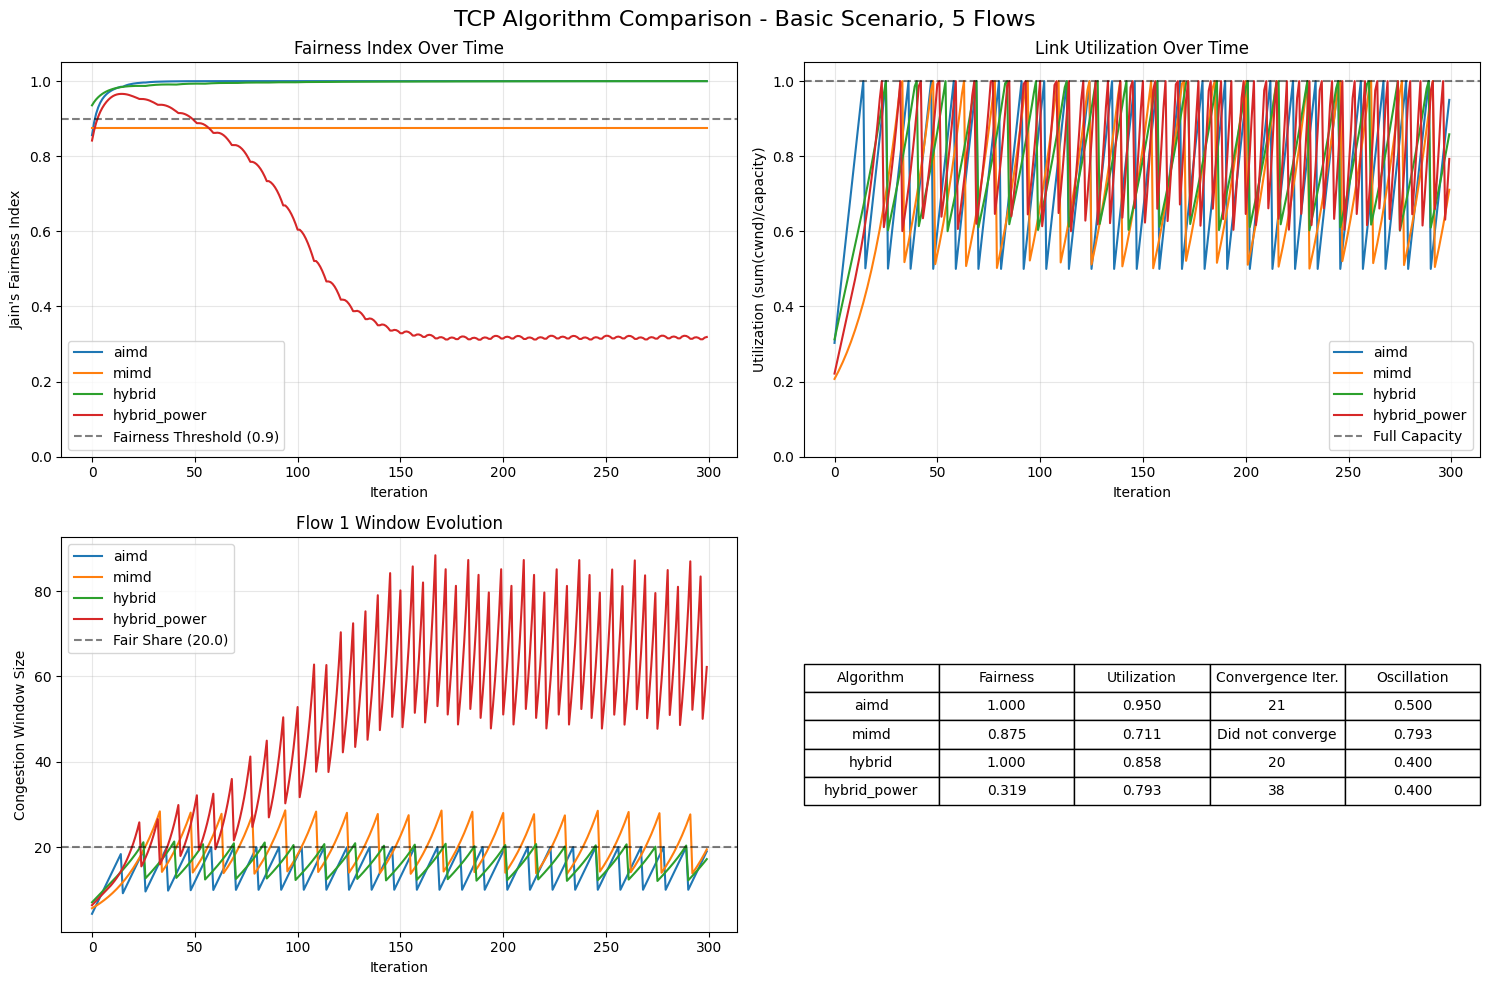

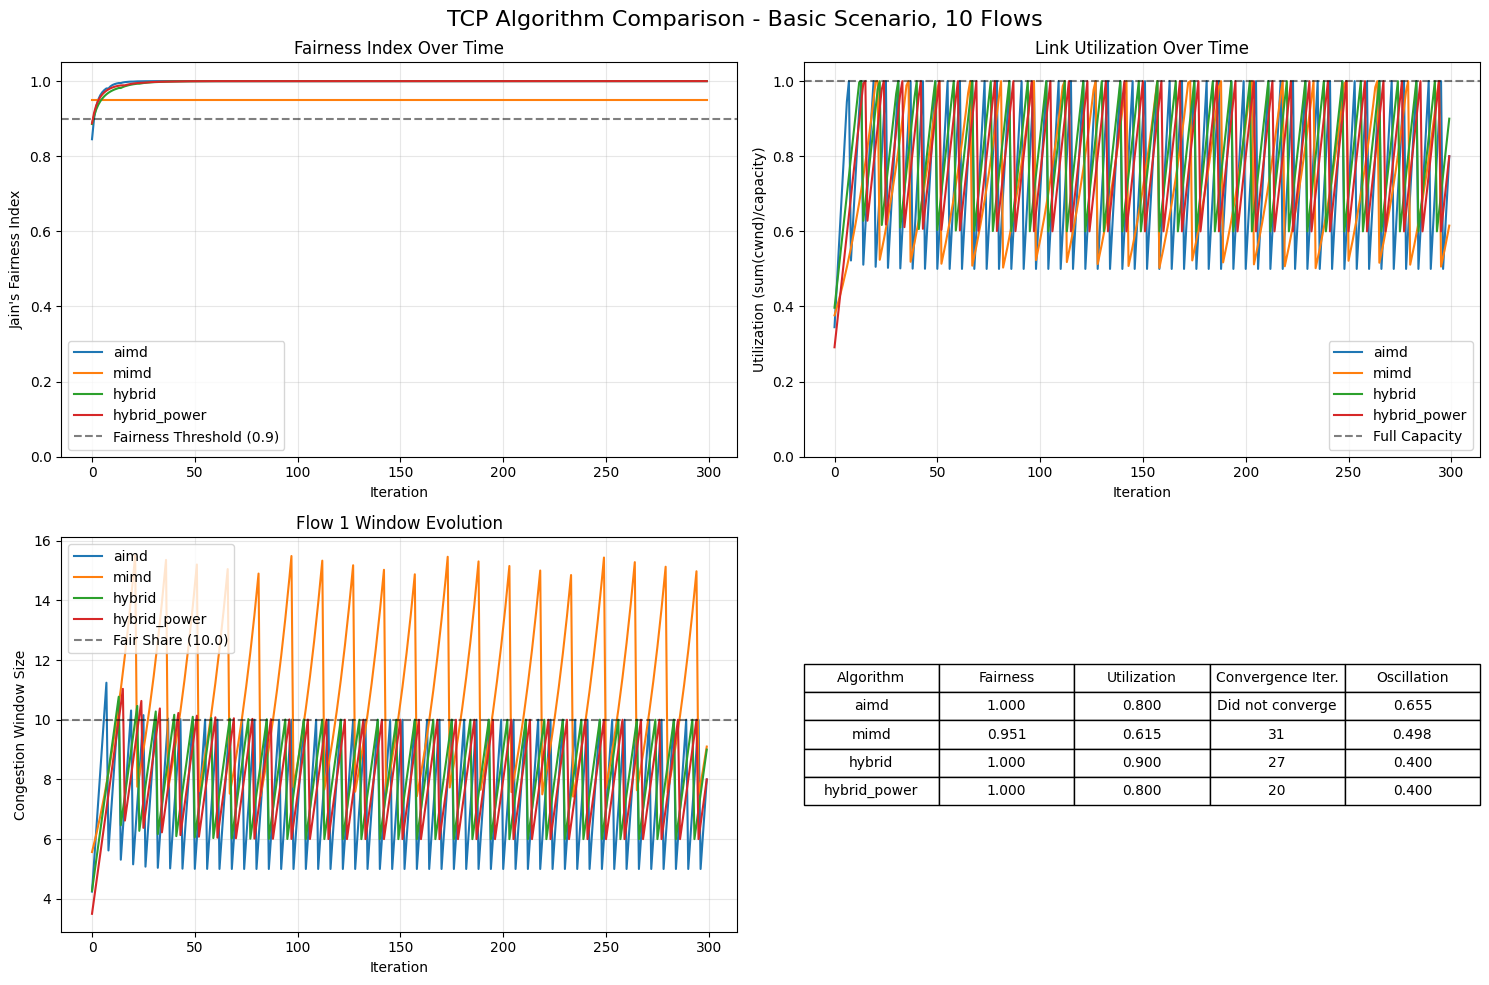

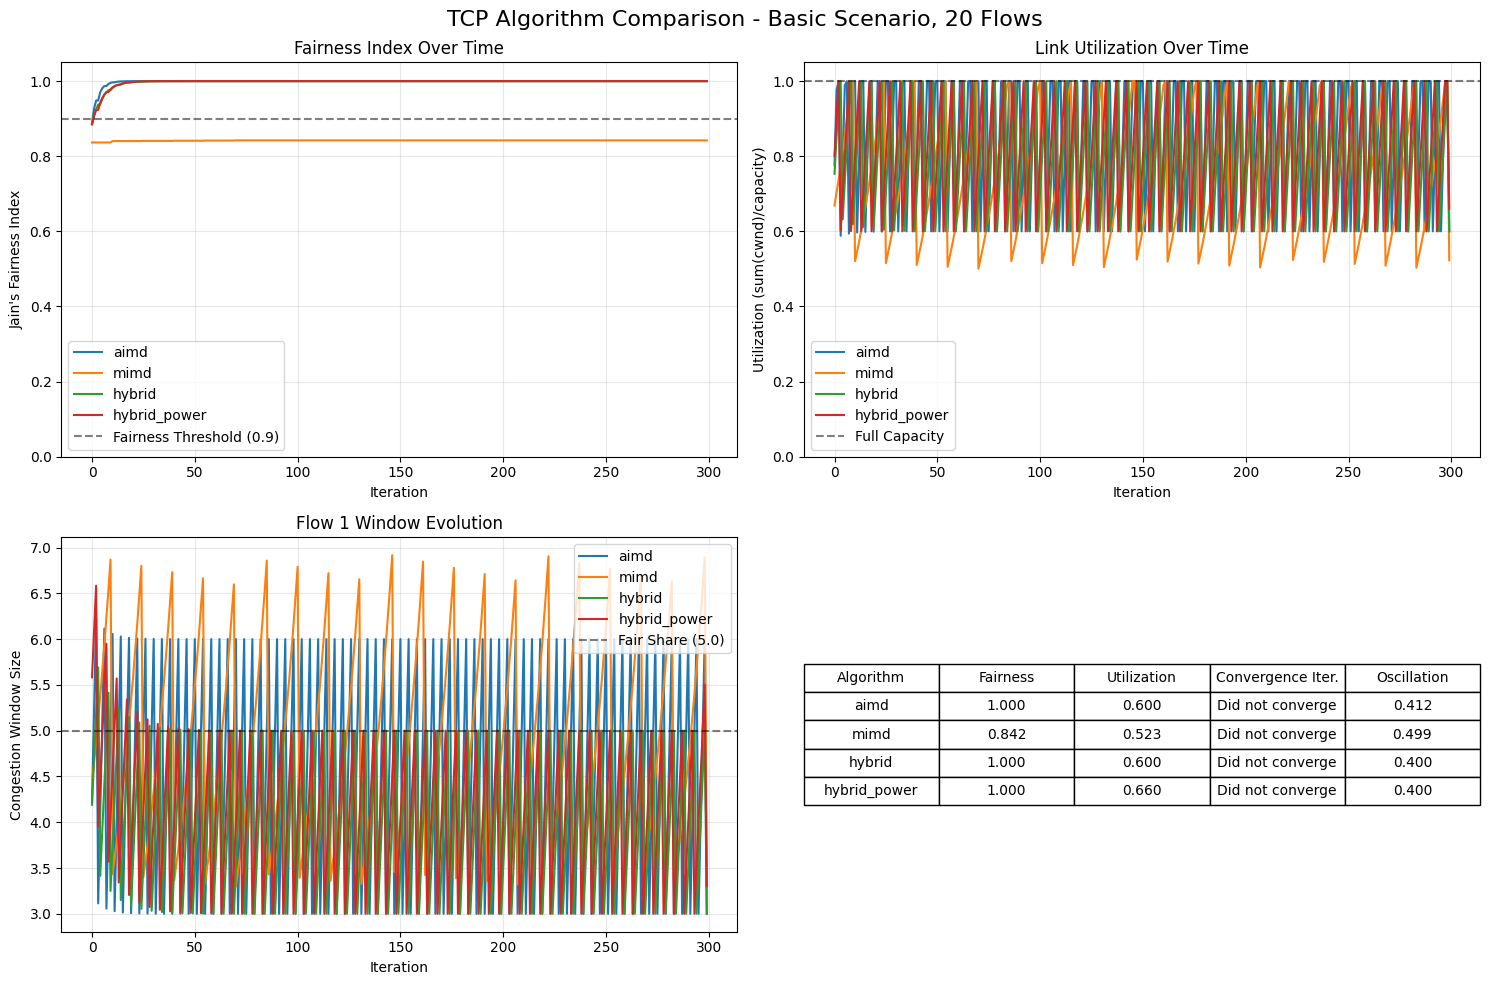

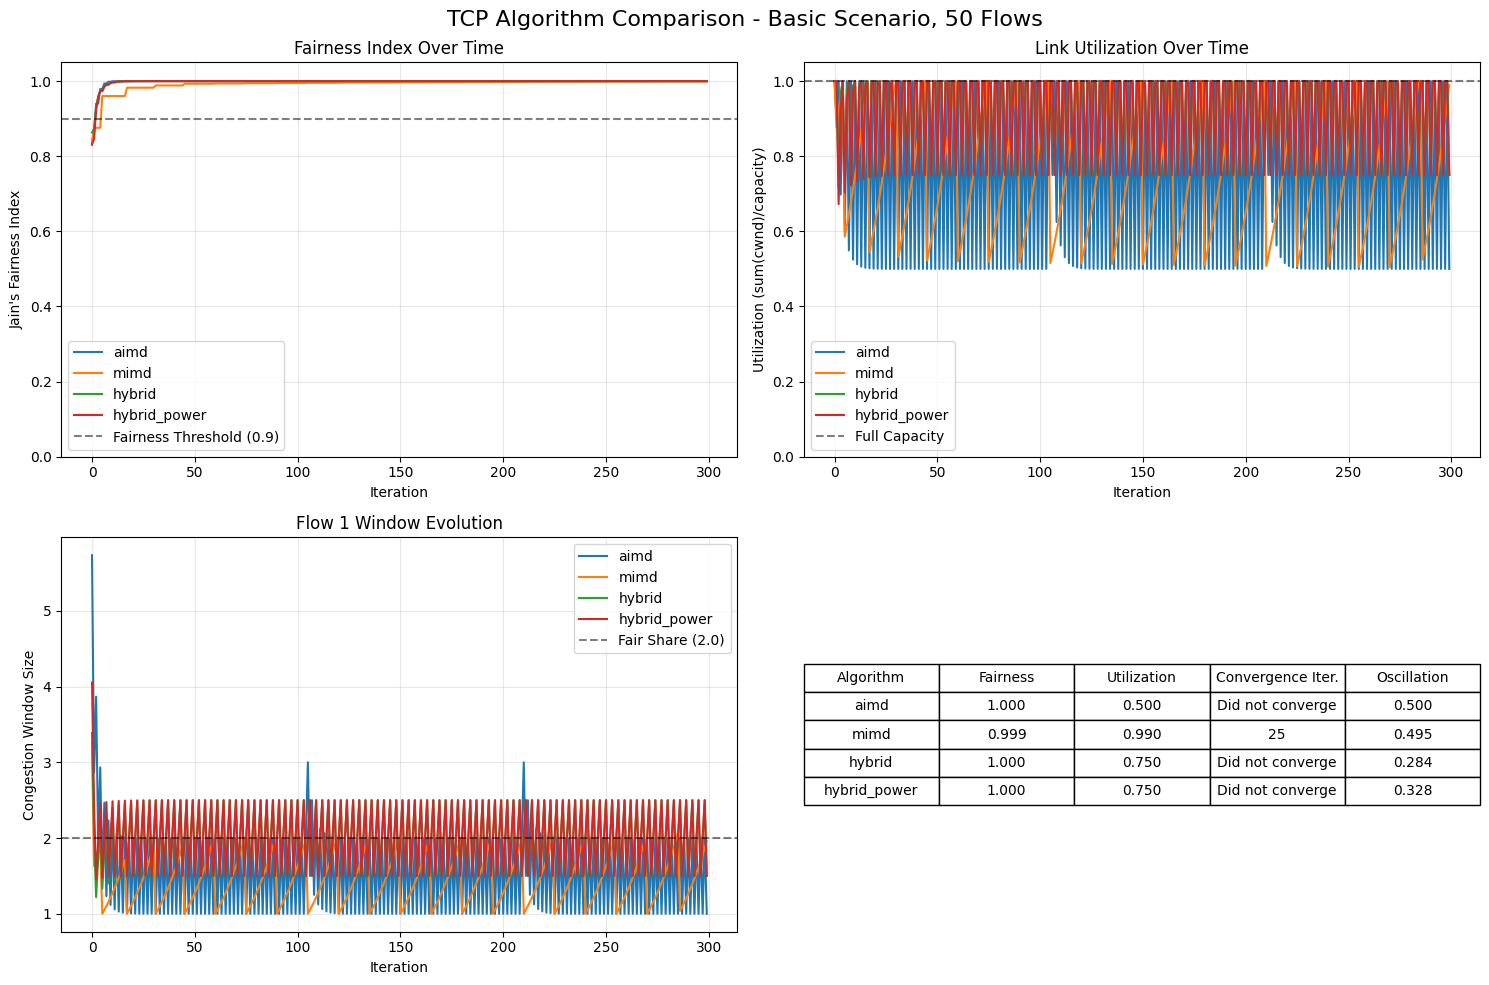

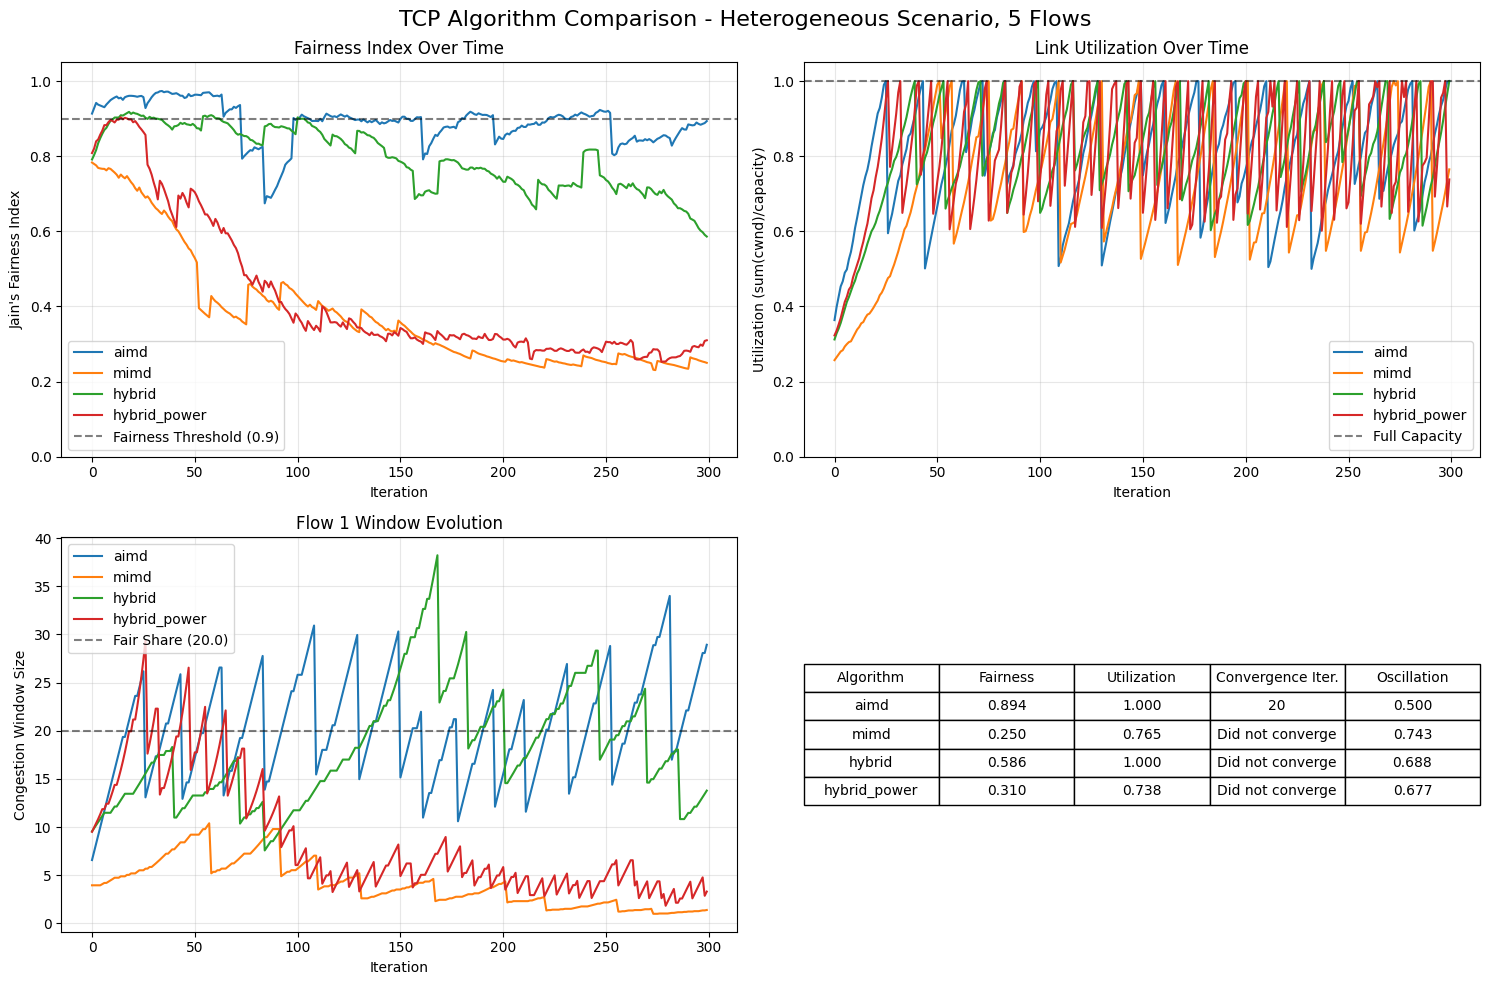

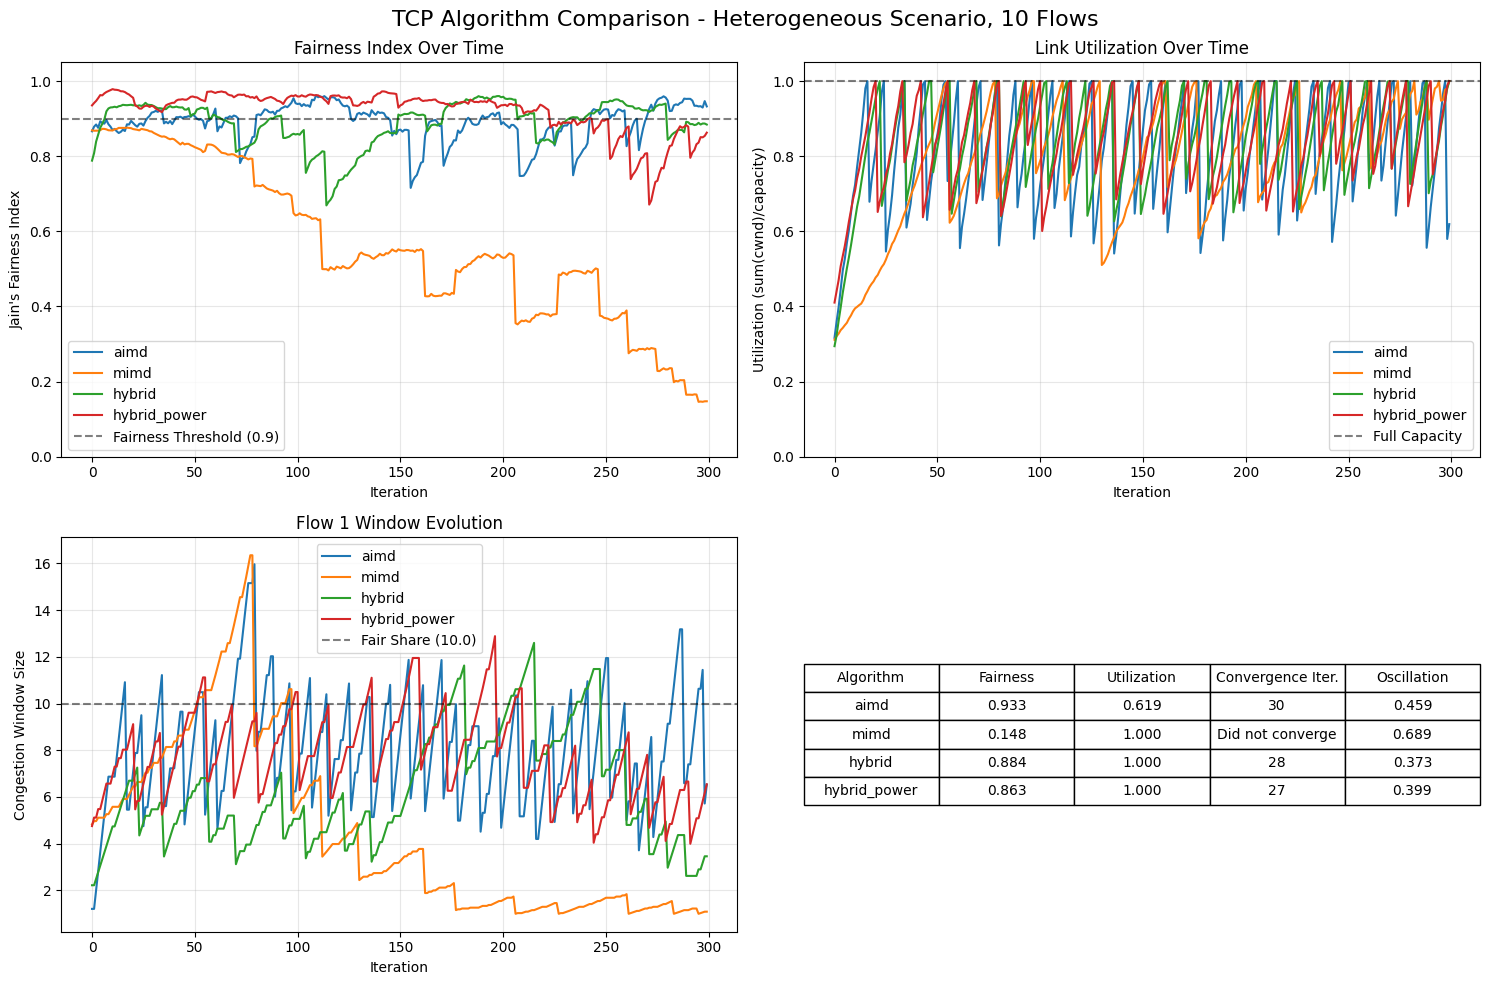

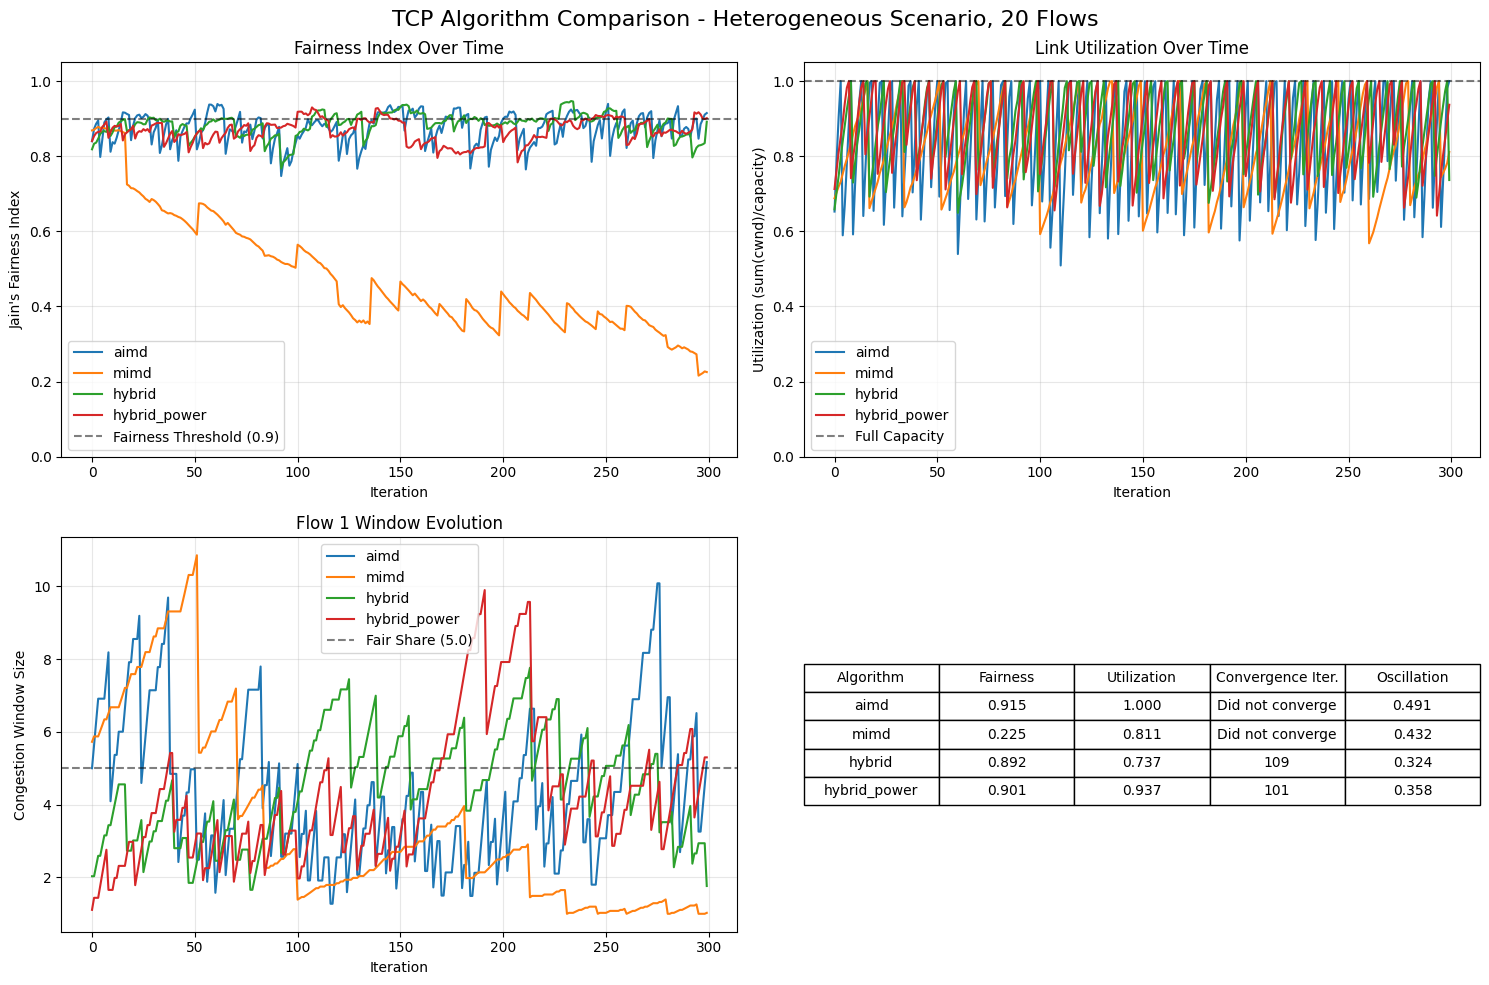

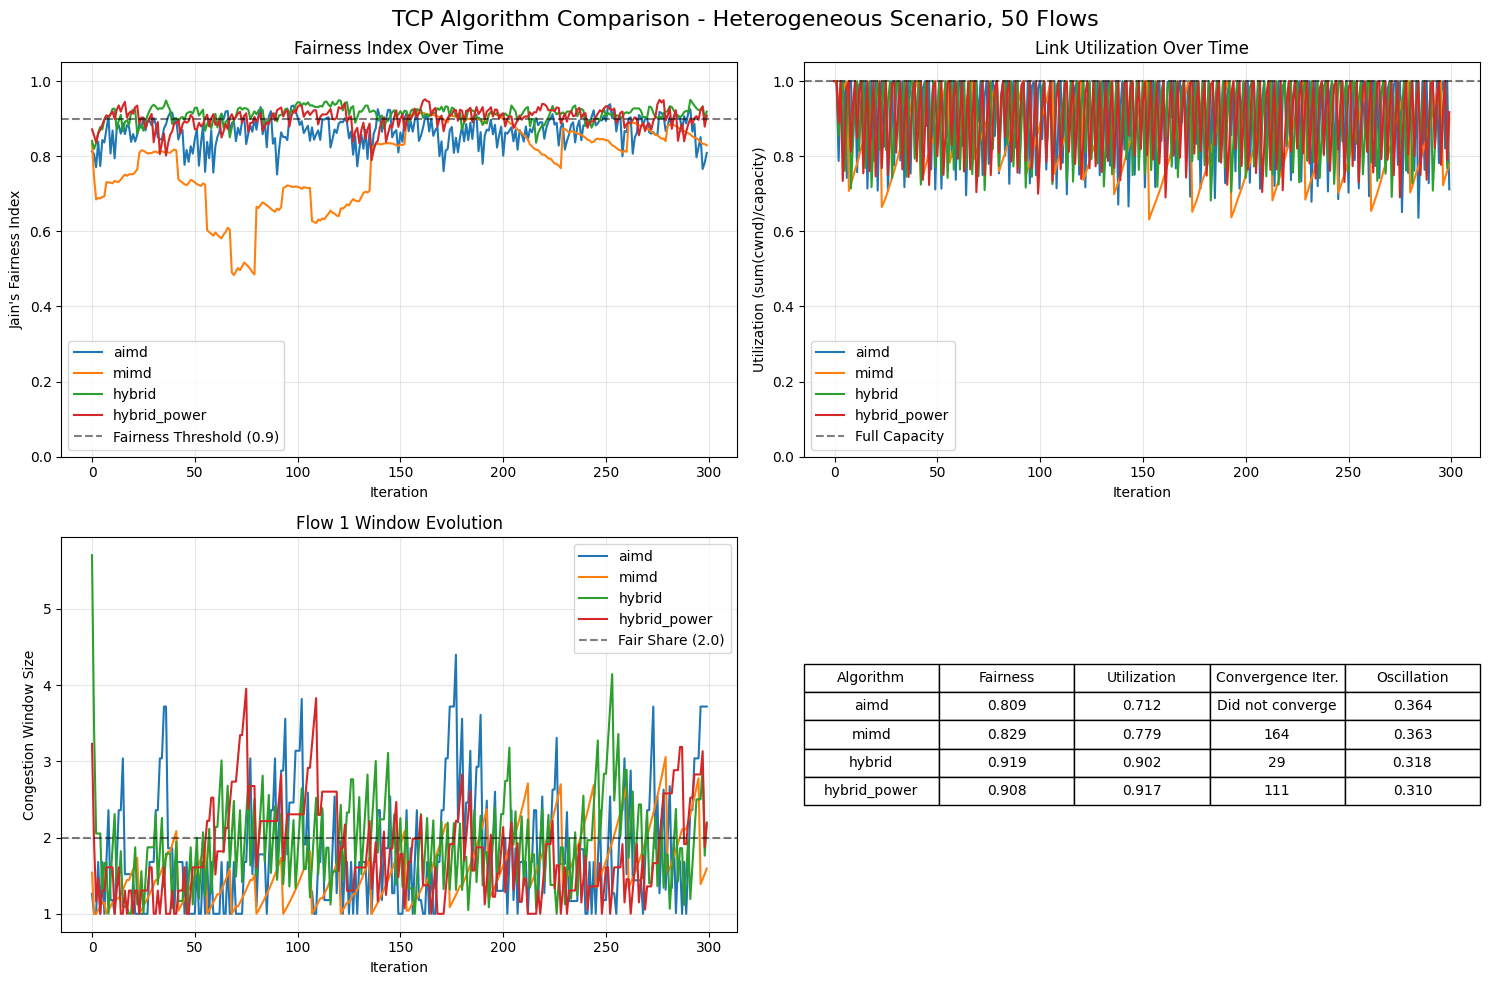

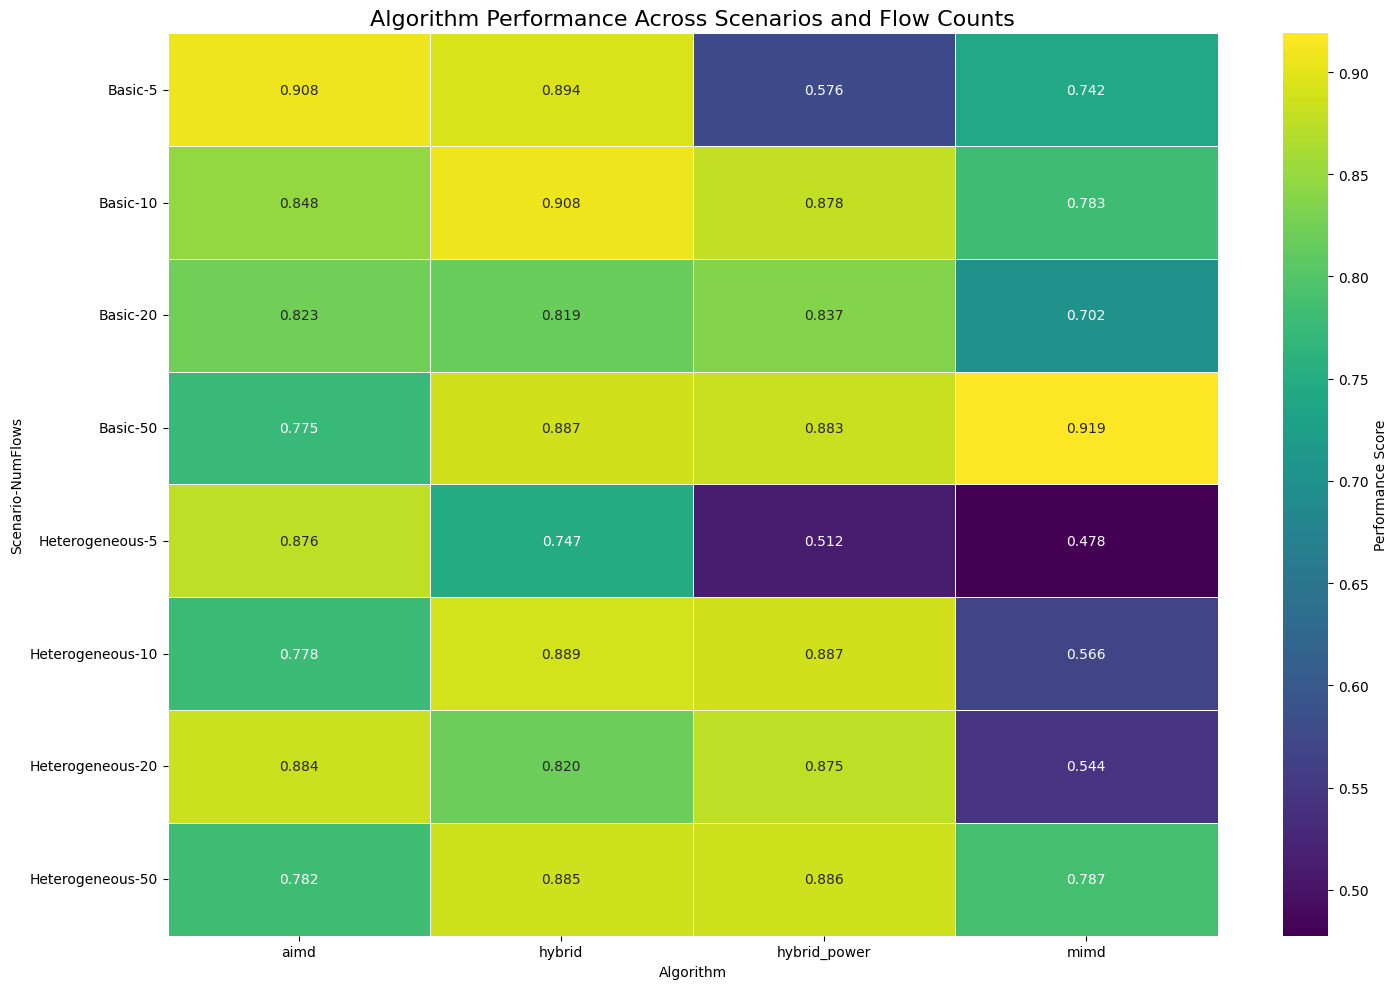

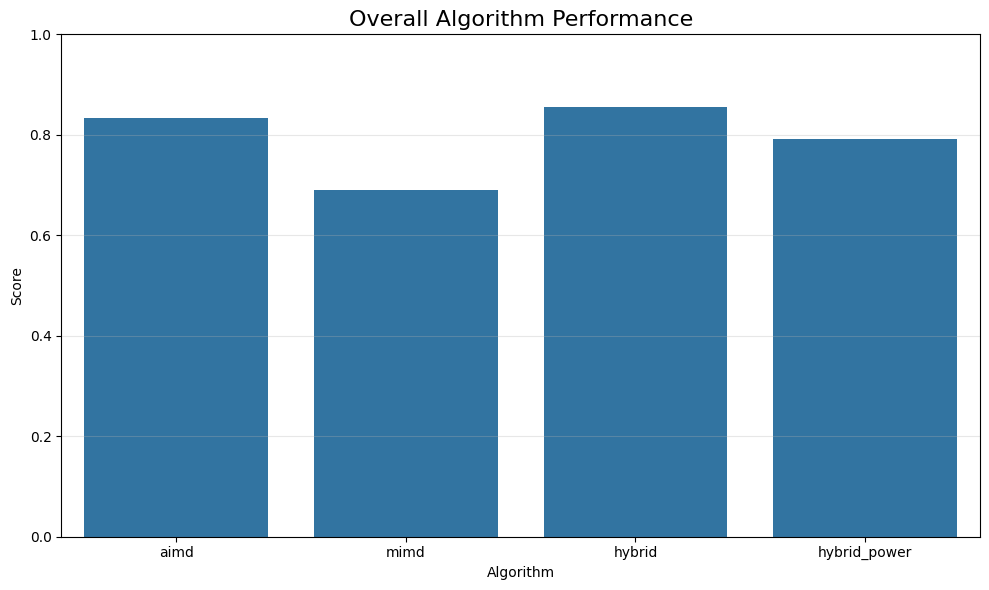

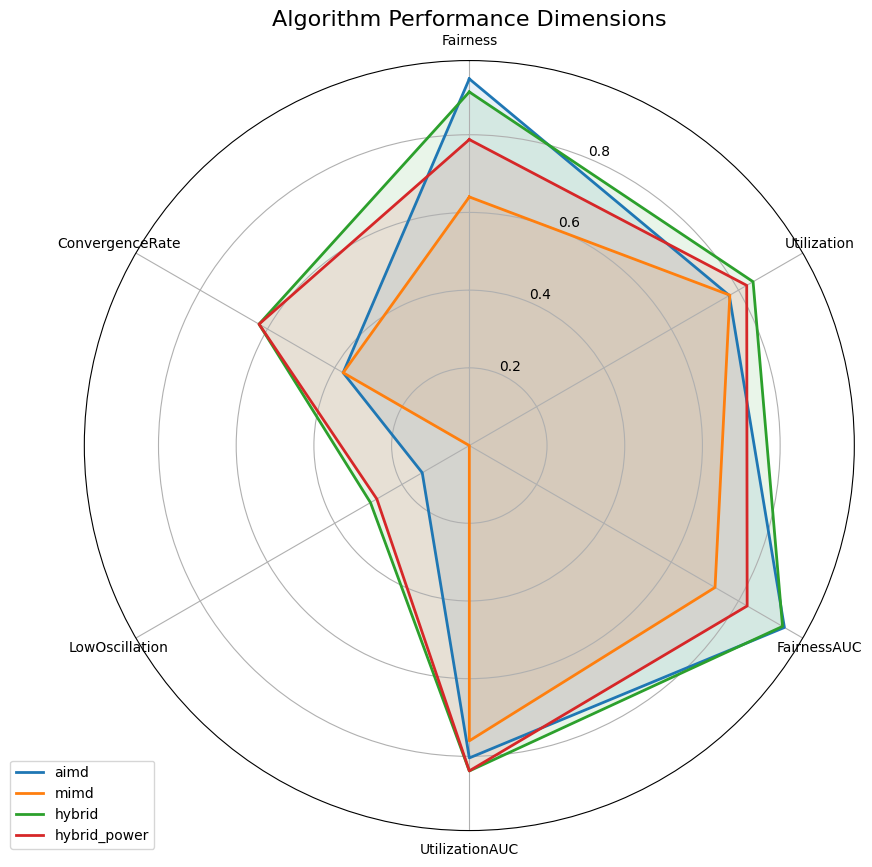

In [12]:
def run_experiment():
    print("Running TCP Congestion Control Algorithm Comparison")
    
    # Define experiment parameters
    num_flows_list = [5, 10, 20, 50]
    capacity = 100.0
    # Only basic and heterogeneous scenarios
    scenarios = ["basic", "heterogeneous"]
    alg_names = ["aimd", "mimd", "hybrid", "hybrid_power"]
    
    # Run the experiment
    results = run_algorithm_comparison(
        num_flows_list=num_flows_list,
        capacity=capacity,
        scenarios=scenarios
    )
    
    # Generate visualizations
    print("\nGenerating visualizations...")
    
    # 1. Individual scenario plots
    for scenario in scenarios:
        for num_flows in [5, 10, 20, 50]:
            fig = plot_algorithm_comparison(results, scenario, num_flows, alg_names)
            plt.savefig(f"{scenario}_{num_flows}flows_comparison.png")
            print(f"  Created {scenario}_{num_flows}flows_comparison.png")
    
    # 2. Summary plots
    summary_df = create_summary_plot(results, scenarios, num_flows_list, alg_names)
    plt.savefig("algorithm_performance_summary.png")
    print("  Created algorithm_performance_summary.png")
    
    # 3. Print summary statistics
    print("\nSummary Statistics:")
    
    # Overall performance by algorithm
    print("\nOverall Performance by Algorithm:")
    alg_scores = summary_df.groupby('Algorithm')['Score'].mean().sort_values(ascending=False)
    for alg, score in alg_scores.items():
        print(f"  {alg}: {score:.4f}")
    
    # Best algorithm by scenario
    print("\nBest Algorithm by Scenario:")
    for scenario in scenarios:
        scenario_df = summary_df[summary_df['Scenario'] == scenario.capitalize()]
        best_alg = scenario_df.groupby('Algorithm')['Score'].mean().idxmax()
        score = scenario_df.groupby('Algorithm')['Score'].mean().max()
        print(f"  {scenario.capitalize()}: {best_alg} (score: {score:.4f})")
    
    # Compare traditional vs. hybrid approaches
    traditional = summary_df[summary_df['Algorithm'].isin(['aimd', 'mimd'])]['Score'].mean()
    hybrid = summary_df[summary_df['Algorithm'].isin(['hybrid', 'hybrid_power'])]['Score'].mean()
    
    print("\nTraditional vs. Hybrid Approaches:")
    print(f"  Traditional (AIMD/MIMD): {traditional:.4f}")
    print(f"  Hybrid Approaches: {hybrid:.4f}")
    print(f"  Improvement: {(hybrid/traditional - 1)*100:.2f}%")
    
    print("\nExperiment complete!")
    
    return results, summary_df

if __name__ == "__main__":
    results, summary_df = run_experiment()

Iteration 0: [ 2.  8. 20.] Fairness: 0.6410256410256411
Iteration 5: [ 3.          6.6        14.01738206] Fairness: 0.7465535097739506
Iteration 10: [ 5.5         9.1        16.85327308] Fairness: 0.8304594071137059
Iteration 15: [ 5.3         7.46       12.12255694] Fairness: 0.8945918840031691
Iteration 20: [4.38       5.676      8.52586161] Fairness: 0.9275012017113172
Iteration 25: [ 6.88        8.176      11.02655461] Fairness: 0.9618277439099677
Iteration 30: [5.528      6.3056     8.02723317] Fairness: 0.9757218971938529
Iteration 35: [ 8.028       8.8056     10.52723502] Fairness: 0.9870589736904034
Iteration 40: [6.4168     6.88336    7.91834294] Fairness: 0.9921909516289561
Iteration 45: [ 8.9168      9.38336    10.41834294] Fairness: 0.9957219405811216
Iteration 50: [7.15008    7.430016   8.05126828] Fairness: 0.9975139815415829
Iteration 55: [ 9.65008     9.930016   10.55127485] Fairness: 0.9985960046229083
Iteration 60: [7.790048   7.9580096  8.33076491] Fairness: 0.99920

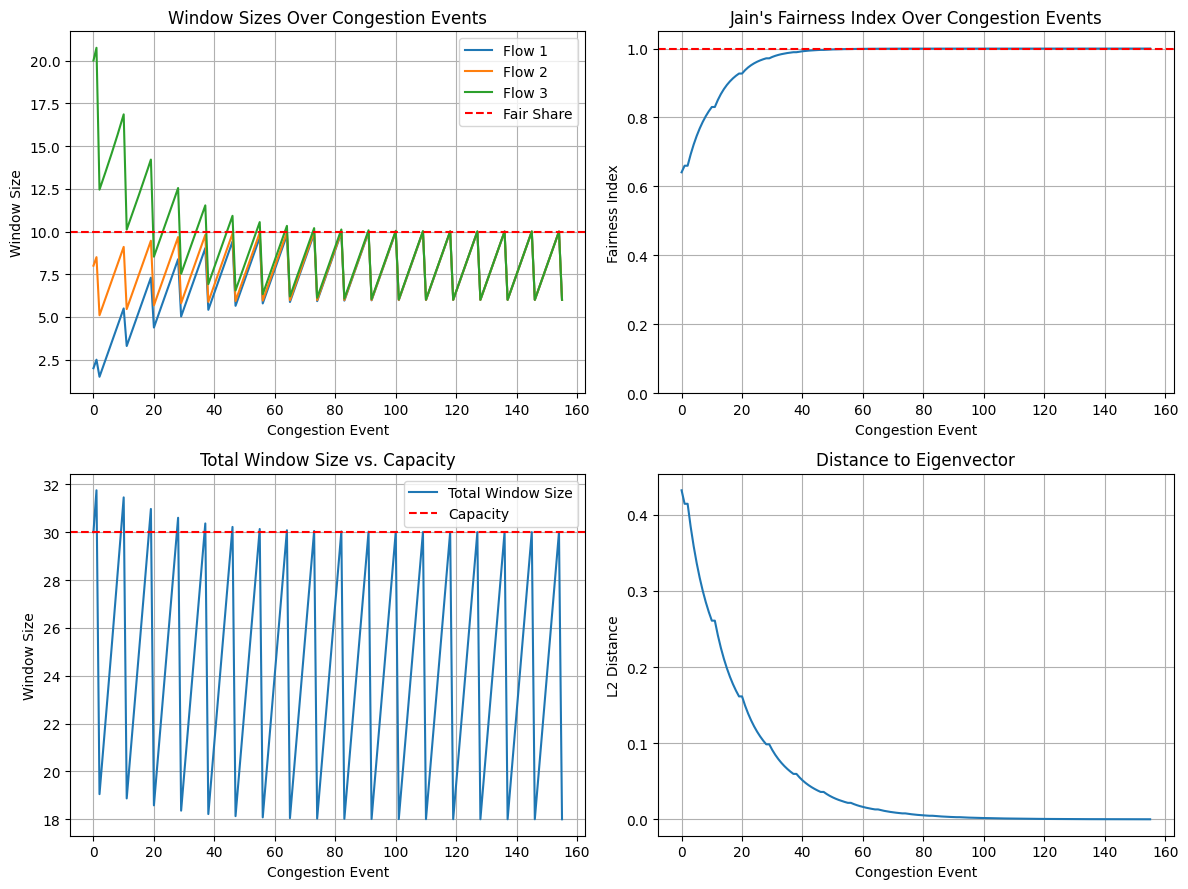


Mathematical Explanation of Hybrid AIMD-MIMD Convergence:

The Hybrid AIMD-MIMD algorithm can be modeled as a time-varying linear system:
w(k+1) = A(k)w(k)
where A(k) depends on the current window sizes w(k).

At each operating point, we can linearize the system and approximate it with a positive matrix A.
According to the Perron-Frobenius theorem, a positive irreducible matrix has a unique
positive eigenvector corresponding to its largest eigenvalue.

As demonstrated by the convergence graphs, the window size vector w(k) converges
to a direction proportional to the Perron-Frobenius eigenvector of the local matrix A.
This ensures that the algorithm reaches a fair equilibrium even with its adaptive nature.


In [25]:
import numpy as np
import matplotlib.pyplot as plt

def hybrid_increase(cwnd, alpha_add, alpha_mult, w_low, w_high):
    """
    Hybrid AIMD-MIMD increase function:
    - If cwnd < w_low: Use AIMD (cwnd += alpha_add)
    - If cwnd > w_high: Use MIMD (cwnd += alpha_mult * cwnd)
    - Otherwise: Linear interpolation between the two
    """
    if cwnd < w_low:
        # Pure AIMD behavior
        return alpha_add
    elif cwnd > w_high:
        # Pure MIMD behavior
        return alpha_mult * cwnd
    else:
        # Linear interpolation between AIMD and MIMD
        ratio = (cwnd - w_low) / (w_high - w_low)
        add_component = alpha_add * (1 - ratio)
        mult_component = alpha_mult * cwnd * ratio
        return add_component + mult_component

def construct_hybrid_matrix(num_flows, betas, alpha_adds, alpha_mults, w_lows, w_highs, window_sizes):
    """
    Construct a matrix approximation for the Hybrid AIMD-MIMD system.
    
    This function creates a linearized approximation of the hybrid algorithm
    based on the current window sizes, using local behavior at the operating point.
    """
    n = num_flows
    # Create diagonal matrix with beta values
    A = np.diag(betas)
    
    # Calculate effective alpha for each flow based on its window size
    effective_alphas = np.zeros(n)
    
    for i in range(n):
        if window_sizes[i] < w_lows[i]:
            # AIMD region
            effective_alphas[i] = alpha_adds[i]
        elif window_sizes[i] > w_highs[i]:
            # MIMD region - linearize around current window size
            # For MIMD: increase = alpha_mult * cwnd
            # Linearized: (alpha_mult * window_sizes[i]) / window_sizes[i] = alpha_mult
            effective_alphas[i] = alpha_mults[i] * window_sizes[i]
        else:
            # Interpolation region
            ratio = (window_sizes[i] - w_lows[i]) / (w_highs[i] - w_lows[i])
            add_component = alpha_adds[i] * (1 - ratio)
            mult_component = alpha_mults[i] * window_sizes[i] * ratio
            effective_alphas[i] = add_component + mult_component
    
    # Calculate one_minus_betas
    one_minus_betas = 1 - np.array(betas)
    
    # Create rank-1 update term
    sum_alphas = np.sum(effective_alphas)
    
    # Handle the case where all effective alphas are zero
    if sum_alphas == 0:
        sum_alphas = 1  # Avoid division by zero
    
    # Create the rank-1 update matrix
    update_matrix = np.outer(effective_alphas, one_minus_betas) / sum_alphas
    
    # Complete matrix A
    A = A + update_matrix
    
    return A, effective_alphas

# Setup for the convergence demonstration
num_flows = 3

# Hybrid AIMD-MIMD parameters (same for all flows for simplicity)
alpha_adds = np.array([0.5, 0.5, 0.5])  # Additive increase parameter
alpha_mults = np.array([0.05, 0.05, 0.05])  # Multiplicative increase parameter
betas = np.array([0.4, 0.4, 0.4])  # Multiplicative decrease factor
w_lows = np.array([10.0, 10.0, 10.0])  # Lower threshold
w_highs = np.array([30.0, 30.0, 30.0])  # Upper threshold

# Initial window sizes (deliberately different to show convergence)
window_sizes = np.array([2.0, 8.0, 20.0])

# Store history for plotting
window_history = [window_sizes.copy()]
fairness_history = []
total_window_history = []

# Calculate initial fairness
def jain_fairness_index(window_sizes):
    n = len(window_sizes)
    if n == 0 or np.sum(window_sizes) == 0:
        return 0.0
    
    numerator = np.sum(window_sizes) ** 2
    denominator = n * np.sum(window_sizes ** 2)
    
    return numerator / denominator

fairness_history.append(jain_fairness_index(window_sizes))
total_window_history.append(np.sum(window_sizes))

# Simulate congestion events
capacity = 30.0  # Link capacity
num_iterations = 155

print("Iteration 0:", window_sizes, "Fairness:", fairness_history[0])

for i in range(num_iterations):
    # Check if we need to apply multiplicative decrease (congestion)
    total_window = np.sum(window_sizes)
    
    if total_window > capacity:
        # Congestion event - apply multiplicative decrease
        window_sizes = window_sizes * (1 - betas)
    else:
        # No congestion - apply additive or multiplicative increase based on window size
        for j in range(num_flows):
            increase = hybrid_increase(
                window_sizes[j], 
                alpha_adds[j], 
                alpha_mults[j], 
                w_lows[j], 
                w_highs[j]
            )
            window_sizes[j] += increase
    
    # Record history
    window_history.append(window_sizes.copy())
    fairness = jain_fairness_index(window_sizes)
    fairness_history.append(fairness)
    total_window_history.append(np.sum(window_sizes))
    
    # Print every 5 iterations
    if (i + 1) % 5 == 0:
        print(f"Iteration {i+1}:", window_sizes, "Fairness:", fairness)

# Calculate the theoretical matrix A and its Perron-Frobenius eigenvector at the final state
final_A, final_effective_alphas = construct_hybrid_matrix(
    num_flows, betas, alpha_adds, alpha_mults, w_lows, w_highs, window_sizes
)

# Calculate eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(final_A)

# Find the index of the eigenvalue with the maximum real part
max_eigenvalue_index = np.argmax(np.real(eigenvalues))

# Extract the corresponding eigenvector
pf_eigenvector = np.real(eigenvectors[:, max_eigenvalue_index])

# Normalize the eigenvector
pf_eigenvector = pf_eigenvector / np.sum(pf_eigenvector)

print("\nFinal Matrix A:")
print(final_A)

print("\nEffective alphas at convergence:", final_effective_alphas)

print("\nPerron-Frobenius right eigenvector of final A:", pf_eigenvector)

print("\nNormalized final window sizes:", window_sizes / np.sum(window_sizes))

# Plot the convergence behavior
plt.figure(figsize=(12, 9))

# Plot 1: Window sizes over iterations
plt.subplot(2, 2, 1)
window_history_array = np.array(window_history)
for j in range(num_flows):
    plt.plot(window_history_array[:, j], label=f'Flow {j+1}')
plt.axhline(y=capacity/num_flows, color='r', linestyle='--', label='Fair Share')
plt.title('Window Sizes Over Congestion Events')
plt.xlabel('Congestion Event')
plt.ylabel('Window Size')
plt.legend()
plt.grid(True)

# Plot 2: Fairness index over iterations
plt.subplot(2, 2, 2)
plt.plot(fairness_history)
plt.axhline(y=1.0, color='r', linestyle='--', label='Perfect Fairness')
plt.title("Jain's Fairness Index Over Congestion Events")
plt.xlabel('Congestion Event')
plt.ylabel('Fairness Index')
plt.ylim(0, 1.05)
plt.grid(True)

# Plot 3: Total window size and capacity
plt.subplot(2, 2, 3)
plt.plot(total_window_history, label='Total Window Size')
plt.axhline(y=capacity, color='r', linestyle='--', label='Capacity')
plt.title('Total Window Size vs. Capacity')
plt.xlabel('Congestion Event')
plt.ylabel('Window Size')
plt.legend()
plt.grid(True)

# Plot 4: Convergence to eigenvector
plt.subplot(2, 2, 4)
normalized_windows = []
for windows in window_history:
    normalized_windows.append(windows / np.sum(windows))
normalized_windows = np.array(normalized_windows)

# L2 distance from each point to the Perron-Frobenius eigenvector
distances = []
for windows in normalized_windows:
    distances.append(np.linalg.norm(windows - pf_eigenvector))

plt.plot(distances)
plt.title('Distance to Eigenvector')
plt.xlabel('Congestion Event')
plt.ylabel('L2 Distance')
plt.grid(True)

plt.tight_layout()
plt.savefig('hybrid_aimd_mimd_convergence.png')
plt.show()

# Mathematical analysis explanation
print("\nMathematical Explanation of Hybrid AIMD-MIMD Convergence:\n")
print("The Hybrid AIMD-MIMD algorithm can be modeled as a time-varying linear system:")
print("w(k+1) = A(k)w(k)")
print("where A(k) depends on the current window sizes w(k).")
print("\nAt each operating point, we can linearize the system and approximate it with a positive matrix A.")
print("According to the Perron-Frobenius theorem, a positive irreducible matrix has a unique")
print("positive eigenvector corresponding to its largest eigenvalue.")
print("\nAs demonstrated by the convergence graphs, the window size vector w(k) converges")
print("to a direction proportional to the Perron-Frobenius eigenvector of the local matrix A.")
print("This ensures that the algorithm reaches a fair equilibrium even with its adaptive nature.")